<a href="https://colab.research.google.com/github/mykon23/AI-2020/blob/master/Activities/Activity19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Iterative Feature Removal and Selection

In [1]:
!wget -O Cy-Young.csv https://github.com/mykon23/AI-2020/blob/master/Data/Cy-Young.csv?raw=True

--2020-11-27 23:37:34--  https://github.com/mykon23/AI-2020/blob/master/Data/Cy-Young.csv?raw=True
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mykon23/AI-2020/raw/master/Data/Cy-Young.csv [following]
--2020-11-27 23:37:34--  https://github.com/mykon23/AI-2020/raw/master/Data/Cy-Young.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Cy-Young.csv [following]
--2020-11-27 23:37:35--  https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Cy-Young.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 20

In [2]:
import pandas as pd

data = pd.read_csv('Cy-Young.csv')
data.head()

,Rank,Name,Tm,Vote Pts,1st Place,Share,WAR,W,L,W-L,ERA,G,GS,GF,CG,SHO,SV,IP,H,R,ER,HR,BB,IBB,SO,HBP,BK,WP,BF,WHIP,ERA+
0,1,Justin Verlander\verlaju01,HOU,171,17,81,7.4,21,6,0.778,2.58,34,34,0,2,1,0,223.0,137,66,64,36,42,0,300,6,0,4,847,0.803,181
1,2,Gerrit Cole\colege01,HOU,159,13,76,6.6,20,5,0.800,2.50,33,33,0,0,0,0,212.1,142,66,59,29,48,0,326,3,3,4,817,0.895,187
2,3,Charlie Morton\mortoch02,TBR,75,0,36,4.9,16,6,0.727,3.05,33,33,0,0,0,0,194.2,154,71,66,15,57,0,240,12,1,5,790,1.084,146
3,4,Shane Bieber\biebesh01,CLE,64,0,30,4.6,15,8,0.652,3.28,34,33,1,3,2,0,214.1,186,86,78,31,40,1,259,6,1,6,859,1.054,145
4,5,Lance Lynn\lynnla01,TEX,18,0,9,7.5,16,11,0.593,3.67,33,33,0,0,0,0,208.1,195,89,85,21,59,0,246,8,0,18,875,1.219,141


In [3]:
##Set the features of interest and the output
features = ['WAR', 'ERA', 'W', 'IP', 'BB', 'SO', 'WHIP']
output = ['Vote Pts']

In [4]:
import numpy as np

work_data = data[features + output].to_numpy()
np.random.shuffle(work_data)

##Define the split point for the training set and the validation set
split_pt = int(0.25 * len(work_data))

##Set the data as two new tensors to permit normlalization
TRAIN = work_data[split_pt:]
VALID = work_data[:split_pt]

XTRAIN = TRAIN[:, :-1]
XVALID = VALID[:, :-1]

YTRAIN = TRAIN[:, -1]
YVALID = VALID[:, -1]

##Normalize the training set
mean = XTRAIN.mean(axis = 0)
XTRAIN -= mean
std = XTRAIN.std(axis = 0)
XTRAIN /= std

##Normalize the validation set
XVALID -= mean
XVALID /= std

Define Evaluation Utilities

In [5]:
import matplotlib.pyplot as plt
from sklearn import metrics

class PlotUtil:
  @staticmethod
  def get_learning_curve(history):
    f, ax = plt.subplots()
    ax.plot(history.history['loss'], '-', label = 'Training', color = 'blue')
    ax.plot(history.history['val_loss'], '--', label = 'Validation', color = 'orange')
    ax.set_ylabel('Loss')
    ax.set_xlabel('epoch')
    ax.set_yscale('log')
    ax.legend()
    return (f, ax)

class RegEvalUtil:
  @staticmethod
  def get_eval_metrics(y_true, y_pred):
    return { 'mse': metrics.mean_squared_error(y_true, y_pred),
            'mae': metrics.mean_absolute_error(y_true, y_pred) }

Define Model Utilities

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class ModelUtil:
  @staticmethod
  def get_model(input):
    model = Sequential()
    model.add( Dense(21, input_dim = input, activation='elu'))
    model.add( Dense(7, activation = 'elu' ))
    model.add( Dense(3, activation = 'elu'))
    model.add( Dense(1, activation = 'elu' ))
    return model
  @staticmethod
  def get_callbacks(model_path):
    return [ ModelCheckpoint(filepath = model_path, 
                        monitor='val_loss', save_best_only = True, 
                        save_weights_only = True, verbose = 0), 
             EarlyStopping(monitor='val_loss', mode='min', 
                           patience=52, verbose=0) ]

DEFAULT_EPOCHS = 512
DEFAULT_BATCH = int(32 * 2)

##Feature Significance

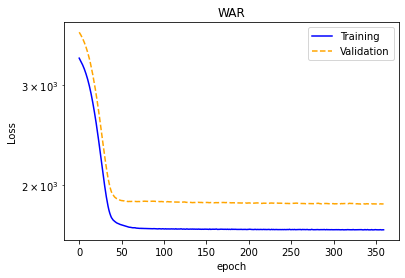

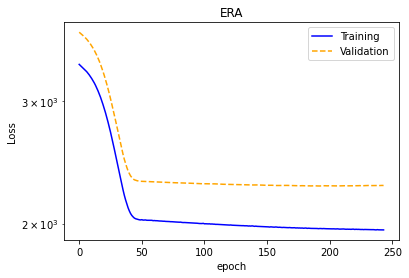

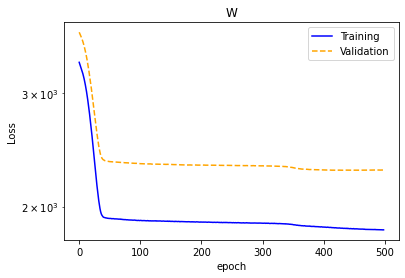

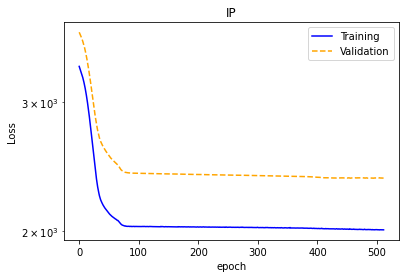

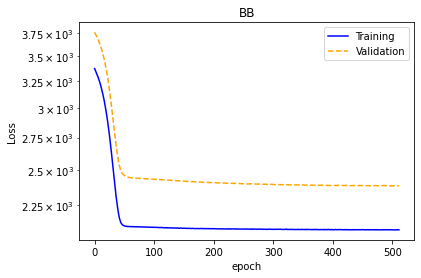

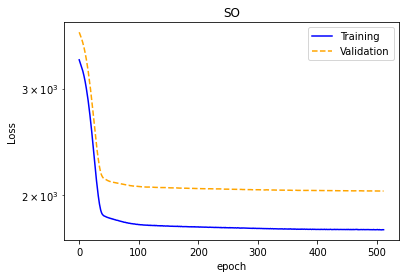

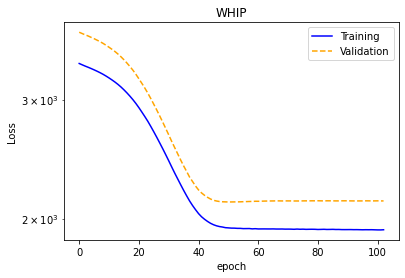

In [7]:
##Keep a dictionary to keep track of the loss
val_loss = {}

##Set the model with default weights
DEFAULT_WEIGHTS = 'default.hdf5'
model = ModelUtil.get_model(1)
model.save_weights(DEFAULT_WEIGHTS)

for i in range(len(features)):
  
  model.load_weights(DEFAULT_WEIGHTS)
  model.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'])

  ##Define the model name
  model_path = features[i] + '.hdf5'
  model_callbacks = ModelUtil.get_callbacks(model_path)

  ##Train the model
  history = model.fit( XTRAIN[:,i], YTRAIN[:],
                      validation_data = (XVALID[:,i], YVALID[:]),
                      epochs = DEFAULT_EPOCHS,
                      batch_size = DEFAULT_BATCH,
                      callbacks = model_callbacks,
                      verbose = 0)
  
  ##View the Learning Curve for the model
  figs = PlotUtil.get_learning_curve(history)
  figs[1].set_title(features[i])
  figs[0].show()

  ##Get the predictions from the best weights from model checkpointing
  model.load_weights(model_path)
  train_pred = model.predict(XTRAIN[:, i])
  valid_pred = model.predict(XVALID[:, i])

  eval = { 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)}
  
  val_loss[features[i]] = eval['valid']['mae']


In [8]:
##Sort features by validation loss
ranked_loss = pd.DataFrame( {'feature': val_loss.keys(), 'loss': val_loss.values()}, columns=['feature', 'loss'])
ranked_loss = ranked_loss.sort_values(by = ['loss'])
ranked_loss.head(len(ranked_loss))

,feature,loss
0,WAR,31.843602
5,SO,33.994286
6,WHIP,34.498358
2,W,35.031674
1,ERA,36.210238
3,IP,36.896182
4,BB,37.594976


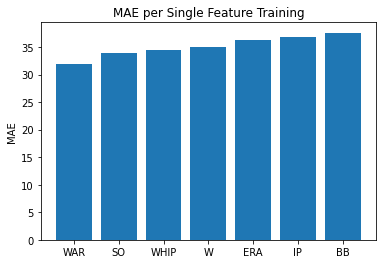

In [9]:
import matplotlib.pyplot as plt

plt.bar(ranked_loss['feature'], ranked_loss['loss'])
plt.ylabel('MAE')
plt.title('MAE per Single Feature Training')
plt.show()

The single feature MAE is sorted in an increasing manner as a low MAE indicates a more accurate prediction.  The less significant features are those that yield a larger MAE as accuracy is inversely proportional to the MAE.

##Feature Reduction

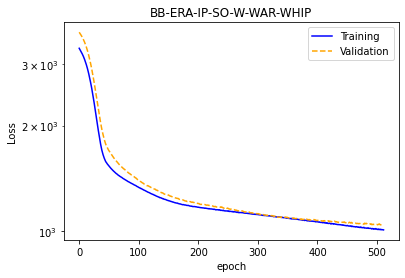

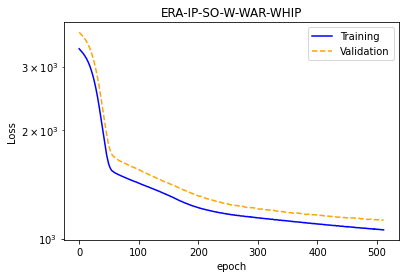

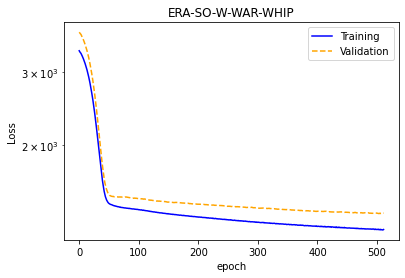

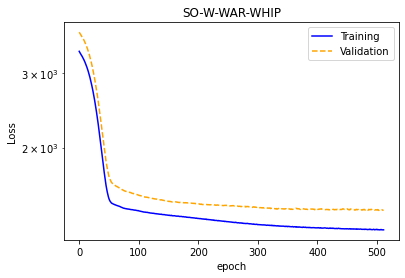

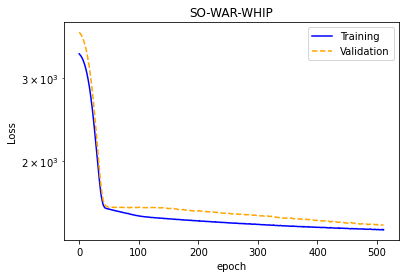

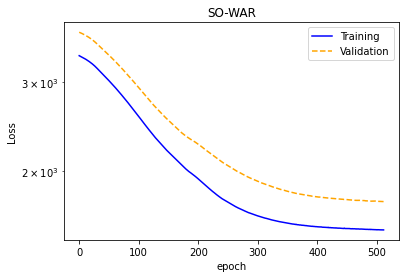

In [10]:
##Set the reduce features list to contain the indices for each features
feature_red = [ features.index(u) for u in ranked_loss['feature']]

##Keep a dictionary to keep track of the loss
val_loss_red = {}

##Train reduced model for features greater than one
while len(feature_red) > 1:

  ##Set the updated np array
  x_train_red = XTRAIN[:, feature_red]
  x_valid_red = VALID[:, feature_red]
  
  model = ModelUtil.get_model(len(feature_red))
  model.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'])

  ##Set the indentifier
  key = '-'.join(sorted([features[i] for i in feature_red]))
  model_path = key + '.hdf5'
  model_callbacks = ModelUtil.get_callbacks(model_path)

  ##Train the model
  history = model.fit( x_train_red, YTRAIN[:],
                      validation_data = (x_valid_red, YVALID[:]),
                      epochs = DEFAULT_EPOCHS,
                      batch_size = DEFAULT_BATCH,
                      callbacks = model_callbacks,
                      verbose = 0)
  
  ##View the Learning Curve for the model
  figs = PlotUtil.get_learning_curve(history)
  figs[1].set_title(key)
  figs[0].show()

  ##Get the predictions from the best weights from model checkpointing
  model.load_weights(model_path)
  train_pred = model.predict(x_train_red)
  valid_pred = model.predict(x_valid_red)

  eval = { 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)}
  
  val_loss_red[key] = eval['valid']['mae']

  ##Remove the least import feature
  feature_red.pop()


In [11]:
##Sort features by validation loss
ranked_loss_red = pd.DataFrame( {'feature': val_loss_red.keys(), 'loss': val_loss_red.values()}, columns=['feature', 'loss'])
ranked_loss_red.head(len(ranked_loss_red))

,feature,loss
0,BB-ERA-IP-SO-W-WAR-WHIP,22.204242
1,ERA-IP-SO-W-WAR-WHIP,22.435081
2,ERA-SO-W-WAR-WHIP,25.798746
3,SO-W-WAR-WHIP,27.021009
4,SO-WAR-WHIP,27.958385
5,SO-WAR,31.087427


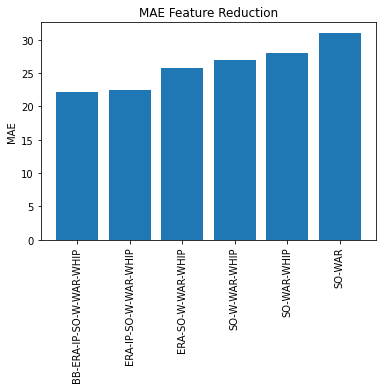

In [12]:
import matplotlib.pyplot as plt

plt.bar(ranked_loss_red['feature'], ranked_loss_red['loss'])
plt.xticks(rotation = 'vertical')
plt.ylabel('MAE')
plt.title('MAE Feature Reduction')
plt.show()

The model's performance begins to degrade as features are omitted from training.  The drop in performance is not surprising given that the hyperparameters were selected based on the input features and adjustments to the input features require a new set of hyperparameters.  The omission of less important features has a smaller impact on the model's performance compared to the more important features as these yield comparable results.